In [1]:
%load_ext autoreload
%autoreload 2

TODO: true/pred distribution of `Methyltrans_Mon`

In [158]:
import pickle as pkl
from hierataxo.util import (
    OrderManager)
from hierataxo import (
    OrderManager,ConcatProteinDataset,
    HierarchicalLossNetwork,
    cal_accuracy,set_seed)
from hierataxo.dataset import ConcatProteinDataModule
from hierataxo.model import HierarESM
# from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, DistributedSampler,random_split
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint,LearningRateMonitor
order_manager=OrderManager(pkl.load(open('taxo_data/hierarchy_order.pkl','rb'))['Riboviria'],
                        level_names=['Kingdom','Phylum','Class','Order'])
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers.tensorboard import TensorBoardLogger
import torch
# L.Trainer()
max_length=500
max_domain=15
train_bs=3
infer_bs=20
seed=42
seed_everything(seed, workers=True)
model=HierarESM(order_manager,max_length=max_length,max_domain=max_domain,
    optimizer_kwargs={'backbone_lr':1e-4,'head_lr':1e-3,'weight_decay':0.01},
    scheduler_kwargs={'warmup_iter_1':20,'warmup_iter_2':30,'warmup_lr':1e-10})
datamodule=ConcatProteinDataModule(order_manager, 'taxo_data/proseq_taxo_1.pkl',  # 'taxo_data/proseq_taxo_single_domain.pkl',
    max_length=max_length,max_domain=max_domain,train_bs=train_bs,infer_bs=infer_bs)
datamodule.setup('fit')

Seed set to 42
/home/taxo_playground/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/taxo_playground/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set t

In [159]:
model.load_state_dict(torch.load('infer/reload_ckpt/seed-10043-last.ckpt')['state_dict']) #'infer/reload_ckpt/seed-77-ep28.ckpt'
model.to(0)
model.eval()

/tmp/ipykernel_160506/3556144807.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('infer/reload_ckpt/seed-10043-last.ckpt')['state_dict']

HierarESM(
  (backbone): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_a

In [147]:
from hierataxo.plot_taxotree import standard_classification_view,configure_rcParams
configure_rcParams()
import matplotlib.pyplot as plt
# model()

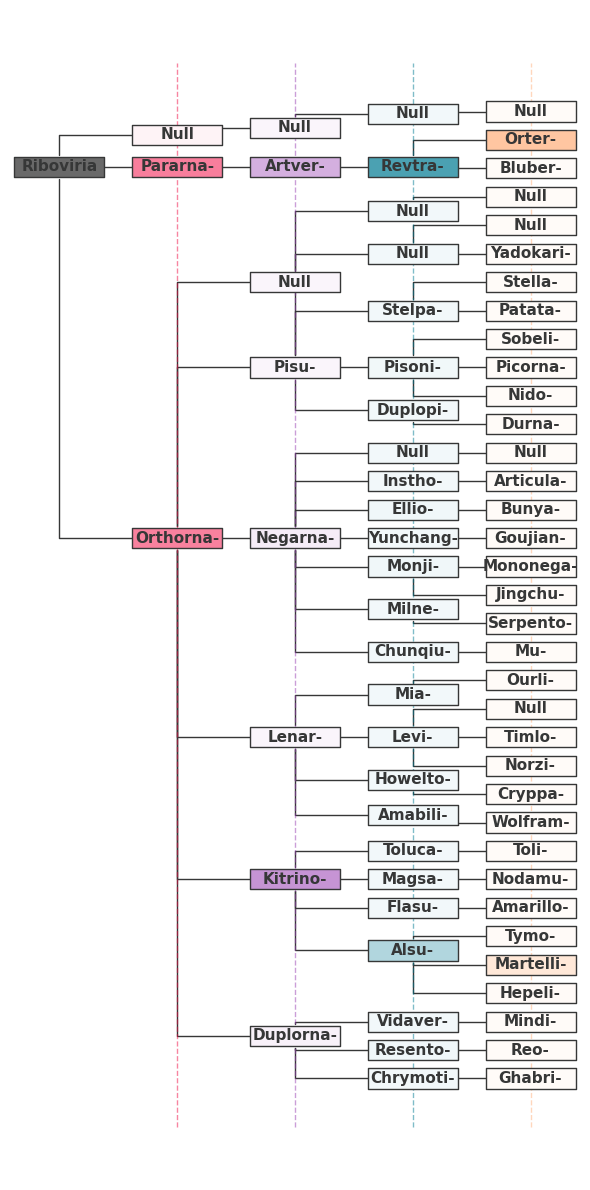

In [160]:

plt.close()
n='UR2SV||M10455'
_=model.forward(need_embed=False,need_pred=True,**model.transfer_batch_to_device(datamodule.dataset.fetch_single(int(datamodule.dataset.name_to_idx(n))),model.device,0))
fig,ax=plt.subplots(1,1,figsize=(6,12))

standard_classification_view(model.order_manager.distribution_to_color_dict(_),ax)
plt.tight_layout()
# plt.savefig('tmp_cm_ana/figs/fig2-confusedpred.svg')
plt.show()

In [161]:
datamodule.dataset.fetch_single(int(datamodule.dataset.name_to_idx(n)))

{'name': ['UR2SV||M10455'],
 'seq': [['EAVIKVISSACKTYCGKTSPSKKEIGAMLSLLQKEGLLMSPSDLYSPGSWDPITAALSQRLMVLGKSGELKTWGLVLGALKAAREE',
   'LNLHKLLGSGAFGEVYEGTALDILADGSGESRVAVKTLKRGATDQEKSEFLKEAHLMSKFDHPHILKLLGVCLLNEPQYLILELMEGGDLLSYLRGARKQKFQSPLLTLTDLLDICLDICKGCVYLEKMRFIHRDLAARNCLVSEKQYGSCSRVVKIGDFGLARDIYKNDYYRKRGEGLLPVRWMAPESLIDGVFTNHSDVWAFGVLVWETLTLGQQPYPGLSNIEVLHHVRSGGRLESPNNCPDDIRDLMTRCWAQDPHNRPTFFYIQHK',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '']],
 'taxo_label': [['Pararnavirae',
   'Artverviricota',
   'Revtraviricetes',
   'Ortervirales']],
 'domain_label': [['Retro_M',
   'PK_Tyr_Ser-Thr',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '']],
 'taxo': tensor([[ 2,  6, 21, 30]]),
 'sentence_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[[ 0,  9,  5,  ...,  1,  1,  1],
          [ 0,  4, 17,  ...,  1,  1,  1],
          [ 0,  2,  1,  ...,  1,  1,  1],
         

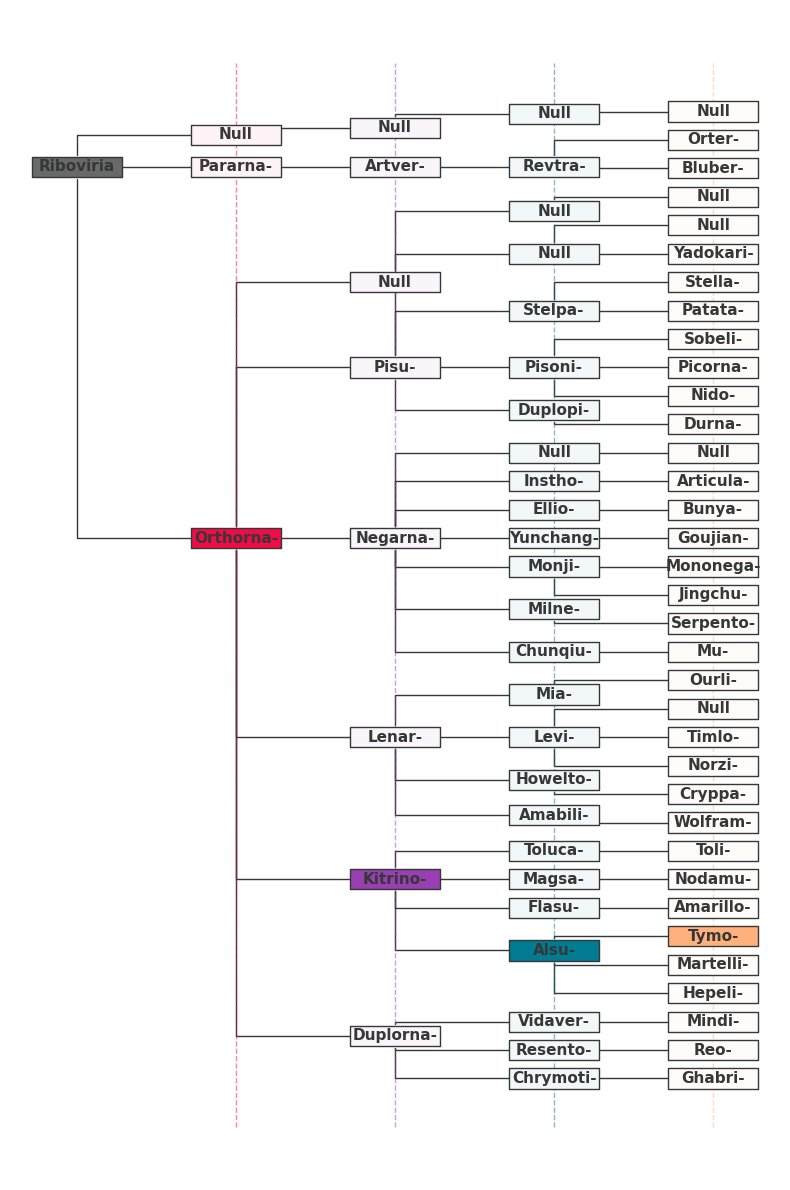

In [156]:
plt.close()
batch=datamodule.dataset.fetch_single(4)
_=model.forward(need_embed=False,need_pred=True,**model.transfer_batch_to_device(batch,model.device,0))
fig,ax=plt.subplots(1,1,figsize=(8,12))

standard_classification_view(model.order_manager.distribution_to_color_dict(_),ax)
plt.tight_layout()
# plt.savefig(f'tmp_cm_ana/figs/fig5-{batch['name'][0].split('-')[-1]}.svg')
plt.show()

In [149]:
batch

{'name': ['AAV1||KF421905-0-Vmethyltransf'],
 'seq': [['HYNMPIEAATKLESFGIITNPYSIALHSHAAAKVCENKLLDTVGHILPKERVTFLFMKPAKRNMLRRSPHLDDYFINQHLEPRDISRYGYESSYDVIPAIPTRVAYMSDTLHFLDVNYVANMFRNSPALDILYATMVLPVEAKFKHPSIHPEIYSINYSHGGFQYIPGNHAGGAYHHEFKQLDWLSVGRIKWKELTDWEEQHCITVQMLEVLGANILYVFKRGNLLTPAVRTFQVDQYVVLPRVFHPQEMNSSRPIKHTLAMQLLLYIKTIGTPTSKDVYGKIRQLVKT',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '']],
 'taxo_label': [['Orthornavirae',
   'Kitrinoviricota',
   'Alsuviricetes',
   'Tymovirales']],
 'domain_label': [['Vmethyltransf',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '']],
 'taxo': tensor([[1, 2, 4, 6]]),
 'sentence_mask': tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[[ 0, 21, 19,  ...,  1,  1,  1],
          [ 0,  2,  1,  ...,  1,  1,  1],
          [ 0,  2,  1,  ...,  1,  1,  1],
          ...,
          [ 0,  2,  1,  ...,  1,  1,  1],
          [ 0,  

In [143]:
datamodule.dataset.fetch_single(1)

{'name': ['AAV1||KF421905'],
 'seq': [['HYNMPIEAATKLESFGIITNPYSIALHSHAAAKVCENKLLDTVGHILPKERVTFLFMKPAKRNMLRRSPHLDDYFINQHLEPRDISRYGYESSYDVIPAIPTRVAYMSDTLHFLDVNYVANMFRNSPALDILYATMVLPVEAKFKHPSIHPEIYSINYSHGGFQYIPGNHAGGAYHHEFKQLDWLSVGRIKWKELTDWEEQHCITVQMLEVLGANILYVFKRGNLLTPAVRTFQVDQYVVLPRVFHPQEMNSSRPIKHTLAMQLLLYIKTIGTPTSKDVYGKIRQLVKT',
   'TPDQLRGRTAGFYSKSMEPYEYTGAKHESLGWPQWLEDFVTTNSINSAMDHCLIQIYDEGAGIPFHKDDEKCYPKDNPILTVNLTGTAEFKIRPAKRWNRTCTHLEHKLGPDSALVMPAGAQKSHQHSVVRCSAGRTSLTFRST',
   'VVIHGAGGSGKSKVIQDFLKTVSVEESYKYTIILPTNELRQDWLTKVRNLEEKSFKTFEKAMLQPCGDIVIFDDYGKMPPGYIEAFAAQQMNGVLYILTGDSRQSVYHESNCDAAIAQLSSNVEEFEQHCRYYLNATHRNRRDLANKLGVYSERDGTTTITHGSTILPGAPVLAPSLMKKSLLGDGGHRSMTYAGCQGLTAPKVQILLDNNTPLCSDKVMYTALSRAIEHVHFIN',
   'LAHIKLFLKSQWVTKMEKAAAQVKPGQTIAAFAQSTVMLYGTMARYMRRIRESFQPPNIMINCEKRLEDLSEFVKTRWRFDKVASSNDYTAFDQSQDGSMLQFEVLKAKHCGVPPEIIEGYIQIKTRAHIFLGVLNIMRLSGEGPTFDANTECSIAYVHTKYHVPAGCNQLYAGDDSAMDDVLEEKPSFANIRAQMKLEEKLQVHAQVKGYFAGFCGNLITPHGLVKDPVKLLAGWKLKKSRG',
   '',
   '',
   '',
   '

In [142]:
datamodule.dataset.fetch_single(int(datamodule.dataset.name_to_idx(n)))

{'name': ['UR2SV||M10455'],
 'seq': [['EAVIKVISSACKTYCGKTSPSKKEIGAMLSLLQKEGLLMSPSDLYSPGSWDPITAALSQRLMVLGKSGELKTWGLVLGALKAAREE',
   'LNLHKLLGSGAFGEVYEGTALDILADGSGESRVAVKTLKRGATDQEKSEFLKEAHLMSKFDHPHILKLLGVCLLNEPQYLILELMEGGDLLSYLRGARKQKFQSPLLTLTDLLDICLDICKGCVYLEKMRFIHRDLAARNCLVSEKQYGSCSRVVKIGDFGLARDIYKNDYYRKRGEGLLPVRWMAPESLIDGVFTNHSDVWAFGVLVWETLTLGQQPYPGLSNIEVLHHVRSGGRLESPNNCPDDIRDLMTRCWAQDPHNRPTFFYIQHK',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '']],
 'taxo_label': [['Pararnavirae',
   'Artverviricota',
   'Revtraviricetes',
   'Ortervirales']],
 'domain_label': [['Retro_M',
   'PK_Tyr_Ser-Thr',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   '']],
 'taxo': tensor([[ 2,  6, 21, 30]]),
 'sentence_mask': tensor([[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
 'input_ids': tensor([[[ 0,  9,  5,  ...,  1,  1,  1],
          [ 0,  4, 17,  ...,  1,  1,  1],
          [ 0,  2,  1,  ...,  1,  1,  1],
         

1323

In [5]:
[i.shape for i in _]

[torch.Size([1, 320]),
 torch.Size([1, 320]),
 torch.Size([1, 320]),
 torch.Size([1, 320])]

In [ ]:
import pytorch_lightning as pl
pl.LightningModule.transfer_batch_to_device

In [3]:
model.to(0)
batch=model.transfer_batch_to_device(datamodule.dataset.fetch_single(1),model.device,0)

In [8]:
b=model._gradient(**batch)

In [15]:
batch['input_ids'].shape

torch.Size([1, 15, 500])

In [25]:
import matplotlib.pyplot as plt
from seaborn import heatmap
# heatmap(b.cpu().numpy(),cmap='RdBu',vmin=-0.0025,vmax=0.0025)

In [12]:
attention_weight,ori_weight,q_mask,tmask=model._attention(
    model.opt_initiator.self_attn,
    **batch
    ) 

In [64]:
model.mhattenions

[MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuanti

In [61]:
model.decoder_1

TransformerDecoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerDecoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
      )
      (multihead_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
      )
      (linear1): Linear(in_features=320, out_features=1280, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=1280, out_features=320, bias=True)
      (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (norm3): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (dropout3): Dropout(p=0.1, inplace=False)
    )
  )
)

In [86]:
[i for i in plt.rcParams if 'size' in i]

['agg.path.chunksize',
 'axes.labelsize',
 'axes.titlesize',
 'boxplot.flierprops.markersize',
 'boxplot.meanprops.markersize',
 'errorbar.capsize',
 'figure.figsize',
 'figure.labelsize',
 'figure.titlesize',
 'font.size',
 'legend.fontsize',
 'legend.title_fontsize',
 'lines.markersize',
 'ps.papersize',
 'xtick.labelsize',
 'xtick.major.size',
 'xtick.minor.size',
 'ytick.labelsize',
 'ytick.major.size',
 'ytick.minor.size']

In [87]:
plt.rcParams['figure.figsize']

[6.4, 4.8]

In [98]:
from hierataxo.plot_taxotree import configure_rcParams
configure_rcParams()

# model=HierarESM(order_manager,max_length=max_length,max_domain=max_domain,
#     optimizer_kwargs={'backbone_lr':1e-4,'head_lr':1e-3,'weight_decay':0.01},
#     scheduler_kwargs={'warmup_iter_1':20,'warmup_iter_2':30,'warmup_lr':1e-10})

domain_label=[i for i in batch['domain_label'][0] if len(i)!=0]
# torch.zeros()
i=0
for mha in model.mhattenions[:9]:

    plt.close()
    h=6 if i==0 else 12
    fig,ax=plt.subplots(1,1,figsize=(6,h))
    attention_weight,ori_weight,q_mask,tmask=model._attention(
        mha,
        **batch)
    
    heatmap(attention_weight.cpu().numpy(),cmap='Blues',
            xticklabels=(domain_label+model.order_manager.level_names)[:attention_weight.shape[1]],
            yticklabels=(domain_label+model.order_manager.level_names)[:attention_weight.shape[0]],
            square=True,cbar=False)
    ax.tick_params(axis='x', labelrotation=0)
    ax.tick_params(axis='y', labelrotation=90)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment('center') 
        label.set_verticalalignment('top') 
        label.set_fontweight('heavy')

    for label in ax.get_yticklabels():
        # label.set_horizontalalignment('center')  
        # label.set_verticalalignment('top') 
        label.set_fontweight('heavy')
    # plt.show()
    fig.savefig(f'tmp_cm_ana/figs/attention-{i}.svg')
    i+=1
    plt.close()
    # break


In [96]:
i

1

In [92]:
model.mhattenions[:9]

[MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuanti

In [71]:
tmask

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True]], device='cuda:0')

In [72]:
q_mask

tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True]], device='cuda:0')

In [47]:
batch['domain_label'][0]

['Vmethyltransf',
 'FTO_NTD',
 'Viral_helicase1',
 'RdRP_3',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '']

In [33]:
model.decoder_1.layers[0].multihead_attn

MultiheadAttention(
  (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
)

In [34]:
model.mhattenions

[MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 ),
 MultiheadAttention(
   (out_proj): NonDynamicallyQuantizableLinear(in_features=320, out_features=320, bias=True)
 )]

<Axes: >

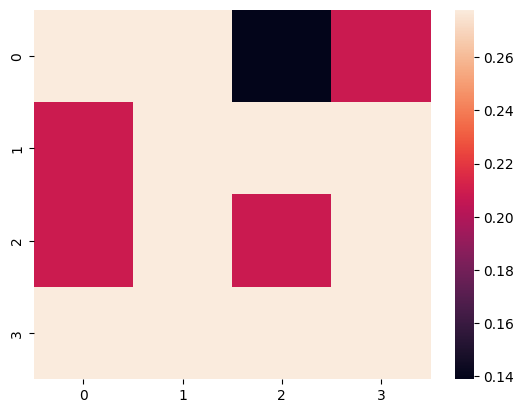

In [28]:
heatmap(ats[0].cpu().numpy())

In [6]:
_=model._attention(
    model.opt_initiator.self_attn,
    **batch
    )

_['key_padding_mask']

tensor([[0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf]],
       device='cuda:0')

In [10]:
_['key_padding_mask'].bool()

tensor([[False, False, False, False,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True]],
       device='cuda:0')

In [68]:
model

HierarESM(
  (backbone): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
      (position_embeddings): Embedding(1026, 320, padding_idx=1)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_a